<a href="https://colab.research.google.com/github/mostafaatefabdelrohem/DeepLearning/blob/main/FERModel_VGG16__Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing import image
from keras_preprocessing.image import ImageDataGenerator,load_img
from keras.models import Model, Sequential
from keras.applications import VGG19
from keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation, GlobalAveragePooling2D
from keras.layers import GaussianNoise
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint,EarlyStopping
from IPython.display import Image, HTML
from keras.utils import plot_model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# declare path
train_dir = '/content/drive/MyDrive/face_emotions/train/'
test_dir = '/content/drive/MyDrive/face_emotions/test/'

# Image size

IMAGE_SIZE = (48,48)
IMAGE_SHAPE = IMAGE_SIZE + (3,)

batch_size = 32
EPOCHS = 50
ADAM_LEARNING_RATE = 0.0001
PATIENCE =10
classes=['Angry','Disgust','Fear','Happy','Neutral','Sad','Surprise']


In [4]:
# Data augmentation

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   featurewise_center=False,
                                   featurewise_std_normalization=False,
                                   rotation_range=10,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [ ]:
# Load datasat

train_dataset  = train_datagen.flow_from_directory(directory = train_dir,
                                                   target_size = IMAGE_SIZE,
                                                   class_mode = 'categorical',
                                                   batch_size = batch_size)

test_dataset = test_datagen.flow_from_directory(directory = test_dir,
                                                  target_size = IMAGE_SIZE,
                                                  class_mode = 'categorical',
                                                  shuffle =True,
                                                  batch_size = batch_size)

In [ ]:
# Total train/test sample

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')

HTML(train_count.append(test_count).to_html(escape=False))


In [ ]:
# Data labels

class_labels = test_dataset.class_indices
class_labels

In [ ]:
# See the shape of any data

train_sample=next(train_dataset)
print(train_sample[0].shape)

In [ ]:
# # lot distribution of train/test dataste per class

x = list(test_count.columns)
y1 =train_count.iloc[0].to_list()
y2 = test_count.iloc[0].to_list()
plt.figure(figsize=(12,7))

plt.bar(x, y1, color='grey')
plt.bar(x, y2, bottom=y1, color='black')
plt.xlabel("Emotions")
plt.ylabel("Train & Test data")
plt.legend(["Train", "Test"], loc='upper left')
plt.title("Data")
plt.savefig('distribution.png')
plt.show()

In [ ]:
# Plot image of each class

plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_dir):
    img = load_img((train_dir + expression +'/'+ os.listdir(train_dir + expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

In [ ]:
# VGG16

base_model = tf.keras.applications.VGG19(input_shape= IMAGE_SHAPE,include_top=False,weights="imagenet")
base_model.summary()

In [ ]:
for layer in base_model.layers[:12]:
    layer.trainable=False

In [ ]:
# Build transfer learning Model

model=Sequential()
model.add(base_model)
model.add(BatchNormalization())
model.add(GaussianNoise(0.01))
model.add(GlobalAveragePooling2D())

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(7, activation="softmax"))

model.summary()

In [ ]:
# Model trainable

print("Model trainable",len(model.trainable_variables))

In [ ]:
# Compile model



METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy')
    
]

adam = tf.keras.optimizers.Adam(learning_rate=ADAM_LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(optimizer=adam, loss='categorical_crossentropy',metrics=METRICS)

In [ ]:

lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = PATIENCE,verbose = 1,factor = 0.50, min_lr = 1e-10) 
mcp = ModelCheckpoint('model.h5')
es = EarlyStopping(verbose=1, patience=20)

history=model.fit(train_dataset,
                  validation_data=test_dataset,
                  epochs = EPOCHS,
                  verbose =1,
                  callbacks = [lrd,mcp,es])

In [ ]:
#  Som Scores of train & test set

train_evalation = model.evaluate(train_dataset)
test_evaluation = model.evaluate(test_dataset)

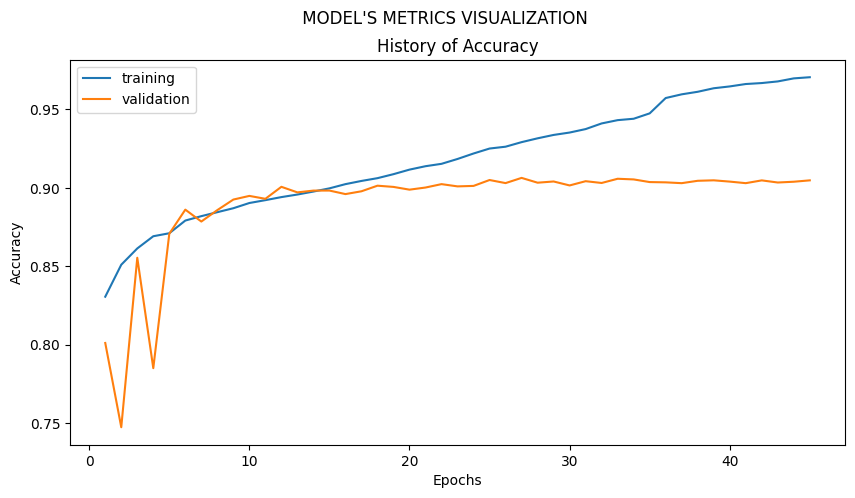

In [ ]:
hs=history.history

acc = hs['accuracy']
val_acc = hs['val_accuracy']
loss =  hs['loss']
val_loss = hs['val_loss']
 
plt.style.use('default')

fig, (ax1) = plt.subplots(1,1, figsize= (10,5))
fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

ax1.plot(range(1, len(acc) + 1), acc)
ax1.plot(range(1, len(val_acc) + 1), val_acc)
ax1.set_title('History of Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend(['training', 'validation'])


In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


(48, 48, 1)


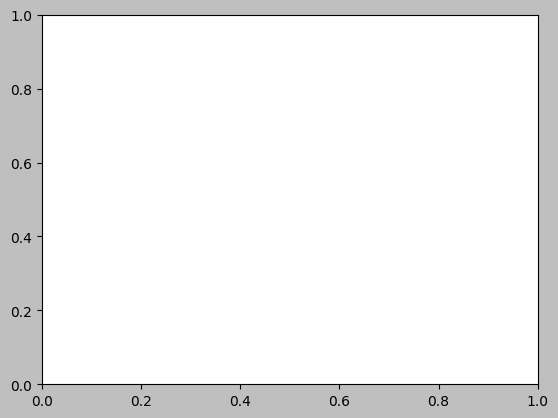

In [ ]:
from tensorflow.keras.preprocessing import image

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

plt.style.use('grayscale')
plt.grid(visible=None)
img_path='/content/drive/MyDrive/face_emotions/test/fear/PrivateTest_10513598.jpg'
test_image=image.load_img(img_path,target_size= (IMAGE_SIZE),color_mode='grayscale')
test_image=image.img_to_array(test_image)
print(test_image.shape)


In [ ]:
img=image.load_img(img_path,target_size=IMAGE_SIZE)
img = np.expand_dims(img, axis=0)
print(img.shape)

(1, 48, 48, 3)


In [ ]:
result=model.predict(img)
print(result[0])
y_pred=np.argmax(result[0])
print('The person facial emotion is:',classes[y_pred])

1/1 [==============================] - 0s 16ms/step
[0.0000000e+00 0.0000000e+00 1.0000000e+00 4.7630534e-25 0.0000000e+00
 0.0000000e+00 0.0000000e+00]
The person facial emotion is: Fear


In [ ]:
from google.colab import files


files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>